In [33]:
import pickle
import os

FOLDER = os.getcwd() + "/20cells"
ASSUMED_NOISE_LEVEL = 1e7

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    psf = pickle.load(file)


In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
from scipy import fftpack
from scipy.ndimage import gaussian_filter
from utils import GetMidPts, InverseMatrix, GetAvgIntensityWithMask, ApproxPSFBesselOptimise
import cv2


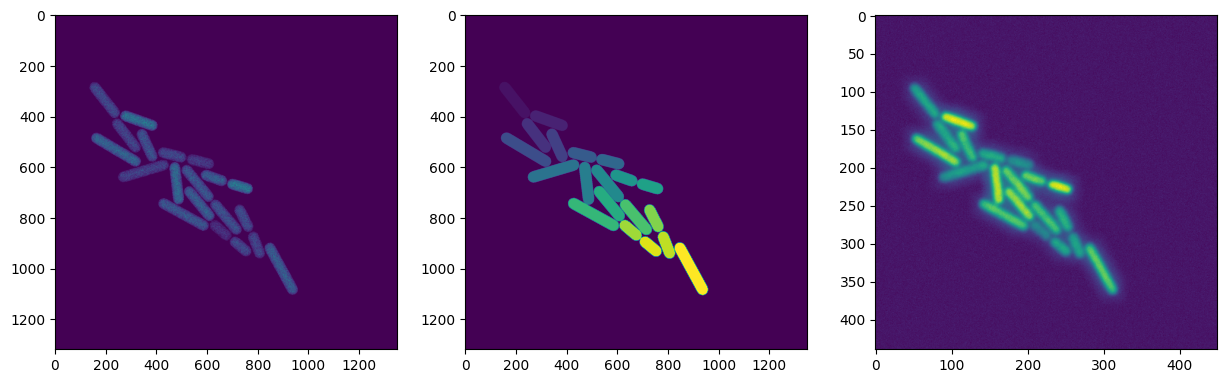

In [35]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

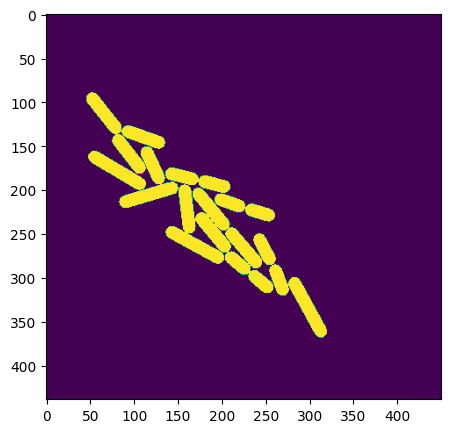

In [36]:
#Apply gaussian filter to out

outBlur = gaussian_filter(out, sigma=1)
plt.imshow(outBlur)

#Resize mask to match out
maskRescale = cv2.resize(mask, outBlur.shape[::-1], interpolation = cv2.INTER_NEAREST)

#IMPT: All mask values are set to one
maskUnit = maskRescale.copy()

for i in range(len(maskUnit)):
    for j in range(len(maskUnit[0])):
        if (maskUnit[i][j] != 0):
            maskUnit[i][j] = 1

plt.imshow(maskUnit)

[123.78024784] [[1.56622993]]


/home/boomalope/anaconda3/envs/symbac/SyMBac/tests/dx_test_env/utils.py:341: RuntimeWarning: invalid value encountered in scalar divide
  return (2*jv(1,x*a) / (x*a))**2


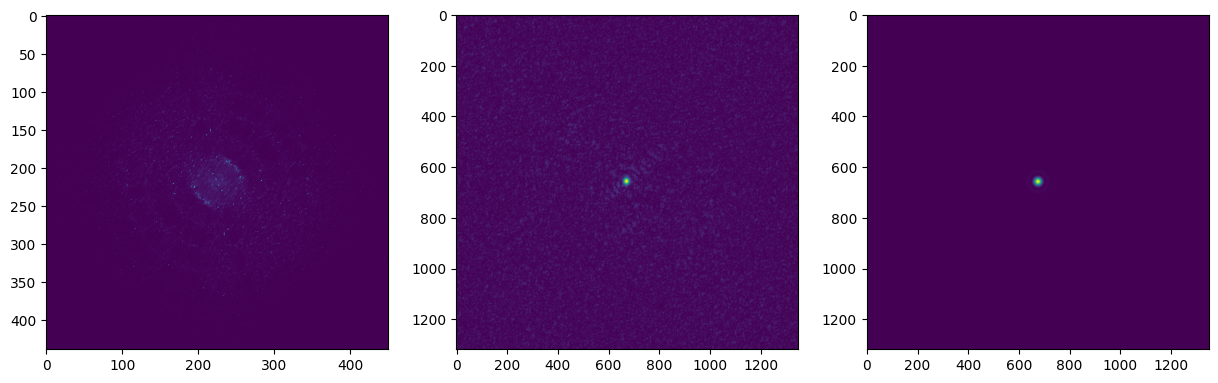

In [37]:
# Compute the 2d FFT of the input image
oriFreq = fftpack.fft2(ori)
maskFreq = fftpack.fft2(maskUnit)
outFreq = fftpack.fft2(outBlur)

# Shift the zero-frequency component to the center of the spectrum.
oriFreq = fftpack.fftshift(oriFreq)
maskFreq = fftpack.fftshift(maskFreq)
outFreq = fftpack.fftshift(outFreq)

#Transform mask.shape into odd values

psfShape = [0,0]
psfShape[0] = mask.shape[0] + 1 if mask.shape[0] % 2 == 0 else mask.shape[0]
psfShape[1] = mask.shape[1] + 1 if mask.shape[1] % 2 == 0 else mask.shape[1]


#We try to find psf with mask instead

psfFreqMask= outFreq * np.conj(maskFreq) / (np.abs(maskFreq)**2 + ASSUMED_NOISE_LEVEL/np.max(np.abs(maskFreq)**2))
psfMask = fftpack.ifft2(psfFreqMask, shape=psfShape)
psfMask = fftpack.fftshift(psfMask)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(np.abs(psfFreqMask))
axarr[1].imshow(np.abs(psfMask))

#Blur psf with gaussian
#psfSmooth = gaussian_filter(np.abs(psfMask), sigma=1)
psfModel = ApproxPSFBesselOptimise(np.abs(psfMask), cutoff = 0.5)

axarr[2].imshow(np.abs(psfModel))
plt.show()

In [38]:
midPts = GetMidPts(maskRescale)
recoveredImage = InverseMatrix(outBlur, maskRescale, midPts, adjPts=0, learningRate = 1, psf=psfModel)

[0.04761905, 0.0952381, 0.14285715, 0.1904762, 0.23809524, 0.2857143, 0.33333334, 0.3809524, 0.42857143, 0.47619048, 0.52380955, 0.5714286, 0.61904764, 0.6666667, 0.71428573, 0.8095238, 0.85714287, 0.9047619, 0.95238096, 1.0]
[[0.62919123]
 [0.99928042]
 [0.55555069]
 [0.66755586]
 [0.84447256]
 [0.60486288]
 [0.50617934]
 [0.57535085]
 [0.90675371]
 [0.79501367]
 [0.75590395]
 [1.        ]
 [0.84532067]
 [0.72458181]
 [0.62739464]
 [0.6178629 ]
 [0.31517735]
 [0.54895863]
 [0.5403146 ]
 [0.80773706]]


/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

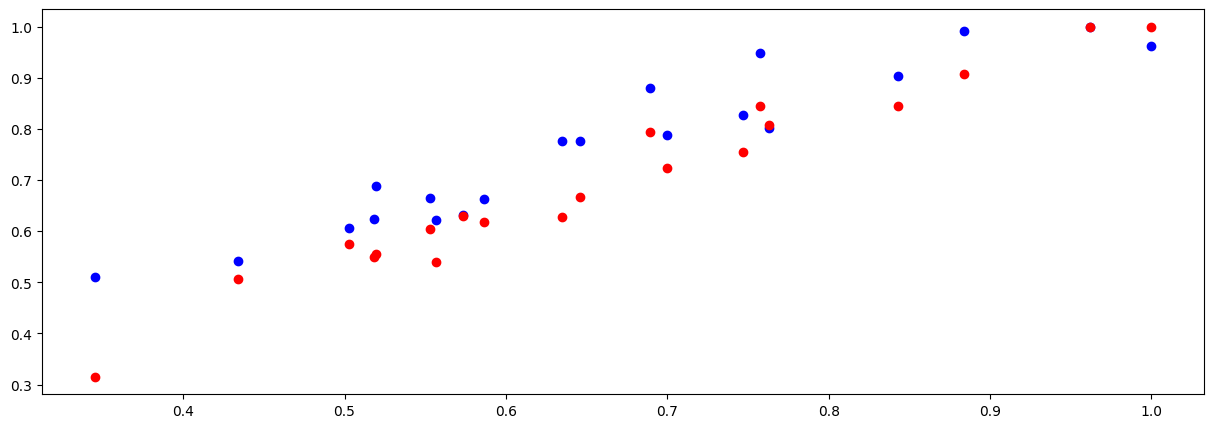

Default:  [[1.         0.94813259]
 [0.94813259 1.        ]]
Custom:  [[1.         0.97986772]
 [0.97986772 1.        ]]


In [39]:
#Get average intensity in each mask

average_original_mask, average_original_intensity = GetAvgIntensityWithMask(ori,mask)
average_output_mask, average_output_intensity = GetAvgIntensityWithMask(out,maskRescale)
average_custom_mask, average_custom_intensity = GetAvgIntensityWithMask(recoveredImage,maskRescale,midPts)

assert(average_custom_intensity.all()==average_original_intensity.all())
assert(average_output_intensity.all()==average_original_intensity.all())

plt.plot(average_original_intensity,average_output_intensity,'bo')
plt.plot(average_original_intensity,average_custom_intensity,'ro')
plt.show()

#Calculate correlation coefficient
print("Default: ", np.corrcoef(average_original_intensity,average_output_intensity))
print("Custom: ", np.corrcoef(average_original_intensity,average_custom_intensity))